# How to Ride the Shopping Cart

## Abstract

Let’s face it: grocery shopping is not a skill most of us intentionally took the time to pursue. However, people more than often find themselves in a situation where they return home with two bags of groceries and realize that they are missing the only item they initially were out for. Sometimes, not having a clear idea about our inventory state, we end up being tempted into the all sorts of treats that are over and above our necessities. Or we buy products to showcase our cooking abilities for the family dinner but somehow we end up with the fridge full of everything, hoping to roll up our sleeves tomorrow. We are often surprised by the amount of items we throw because the expiration date passed two months ago! However, that could change...

## Main Research Question

In this notebook we try to address the following research question:

- Interplay between income and expenses?

### Sub Research Questions

In particular, we are interested in the following sub-questions:

- How do households choose to organize their limited yearly income according to their shopping expenses?

- Can we infer different household types based on the relation between their income and transaction statistics?

- Are some demographic properties of the households indicators of this relation as well i.e. can we infer common family values indirectly from this data?

To begin answering these questions, we first perform data exploration on the **Dunnhumby** dataset to get initial insight for these tasks. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='whitegrid')

In [2]:
DATA_DIR = 'data/'

CAMPAIGN_DESC = 'campaign_desc.csv'
CAMPAIGN_TABLE = 'campaign_table.csv'
CAUSAL_DATA = 'causal_data.csv'
COUPON = 'coupon.csv'
COUPON_REDEMPT = 'coupon_redempt.csv'
HH_DEMOGRAPHIC = 'hh_demographic.csv'
PRODUCT = 'product.csv'
TRANSACTION_DATA = 'transaction_data.csv'

## Part 1: Preprocessing

### Loading the Data

In [3]:
df_hh_demographic = pd.read_csv(DATA_DIR + HH_DEMOGRAPHIC, index_col='household_key')

print('Number of households:', len(df_hh_demographic))

df_hh_demographic.head()

Number of households: 801


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
household_key,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1
13,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2
16,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown


In [4]:
df_transaction_data = pd.read_csv(DATA_DIR + TRANSACTION_DATA, index_col='household_key')

print('Number of transactions:', len(df_transaction_data))

df_transaction_data.head()

Number of transactions: 2595732


/home/korunosk/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
household_key,,,,,,,,,,,
2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


For this research question, we only require the `hh_demographic` and `transaction_data` datasets.

We observe that the `transaction_data` dataset contains a large number (2.5 mil) of transactions. On the other hand, `transaction_data` dataset is much smaller in size (801).

Furthermore, there are transactions for which demographic data is not present. The reason behind the missing demographic information are privacy issues (as stated in the documentation).

### Handling Missing and Inconsistent Data

In [5]:
print('Columns with missing values in household dataset:', np.any(df_hh_demographic.isna().sum()))
print('Columns with missing values in transactions dataset:', np.any(df_transaction_data.isna().sum()))

Columns with missing values in household dataset: False
Columns with missing values in transactions dataset: False


There are none missing values in both datasets.  

However, in the `transaction_data` dataset we observed that some entries contain 0 for `SALES_VALUE` (the total amount received by the retailer) and for `QUANTITY` (the number of products purchased). There may be a valid reason why the data had been recorded this way, however we chose to avoid any assumptions and discard these transactions, as it is only a small percentage of the whole dataset. 

In [6]:
c = (df_transaction_data['SALES_VALUE'] != 0) & (df_transaction_data['QUANTITY'] != 0)

df_transaction_data_cleaned = df_transaction_data[c]

print('Number of transactions:', len(df_transaction_data_cleaned))

Number of transactions: 2576815


Following the previous discussion about missing demographic information, we filter the data:

In [7]:
c = df_transaction_data_cleaned.index.isin(df_hh_demographic.index)

df_transaction_data_cleaned = df_transaction_data_cleaned[c]

print('Number of transactions:', len(df_transaction_data_cleaned))

Number of transactions: 1416672


The `transaction_data` now is half its size before.

**Note**: Although, technically there are none missing values in both datasets, still, the columns: `MARITAL_STATUS_CODE`, `HOMEOWNER_DESC`, and `KID_CATEGORY_DESC` in the `hh_demographic` dataset, take values `U`, `Unknown`, and `None/Unknown` respectively which are unknown values. However, since the columns are categorical, we treat this values as yet another category with hope that later on we can obtain some useful insights.

### Feature Expansion

Using the formulas given in the dataset documentation, we can compute the values most useful for our analysis.

In [8]:
sales_value = df_transaction_data_cleaned['SALES_VALUE']
coupon_desc = df_transaction_data_cleaned['COUPON_DISC']
retail_disc = df_transaction_data_cleaned['RETAIL_DISC']
coupon_match_disc = df_transaction_data_cleaned['COUPON_MATCH_DISC']
quantity = df_transaction_data_cleaned['QUANTITY']

In [9]:
df_transaction_data_cleaned['CUSTOMER_PAID'] = sales_value + coupon_desc
df_transaction_data_cleaned['PRODUCT_PRICE'] = (sales_value - (retail_disc + coupon_match_disc)) / quantity

### Type Conversion

In [10]:
income_desc_categories = [
    'Under 15K',
    '15-24K',
    '25-34K',
    '35-49K',
    '50-74K',
    '75-99K',
    '100-124K',
    '125-149K',
    '150-174K',
    '175-199K',
    '200-249K',
    '250K+'
]

df_hh_demographic['INCOME_DESC'] = pd.Categorical(df_hh_demographic['INCOME_DESC'],
                                                  categories=income_desc_categories,
                                                  ordered=True)

### Joining Datasets

We join the two datasets to obtain the transactions for each household. 

In [11]:
df_households_transactions = df_transaction_data_cleaned.join(df_hh_demographic)

print('Total number of transactions for the selected households:', len(df_households_transactions))

Total number of transactions for the selected households: 1416672


## Part 2: Data Analysis

### Analysis of the Underlying Distributions

The following analysis can help us discover whether people go for quality over quantity, regardless of their annual income.

#### Household Income

The main feature of each household which we will analyze is the `INCOME_DESC` column. It holds information about the total yearly income for each household. The main challenge in answering our questions is the fact that this feature is non numeric - each income value is represented as a category which represents an interval of income values. Looking on the bright side, there is meaningful ordering of the categories as they are intervals. 

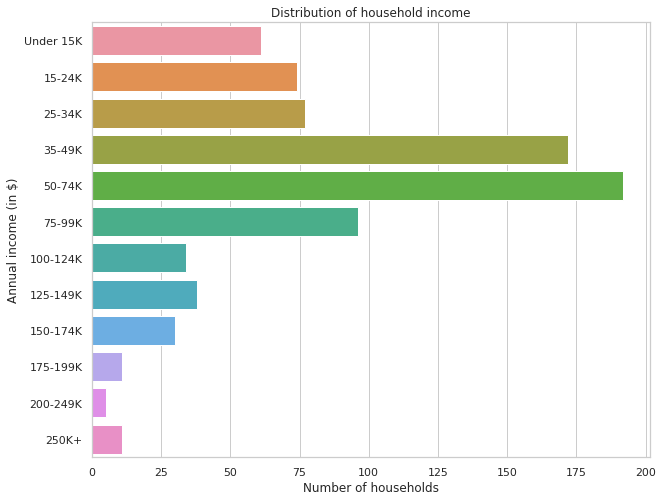

In [12]:
f, ax = plt.subplots(figsize=(10, 8))

income_desc = df_hh_demographic['INCOME_DESC'].value_counts()
sns.barplot(x=income_desc, y=income_desc.index, ax=ax)
ax.set_title('Distribution of household income')
ax.set_xlabel('Number of households')
ax.set_ylabel('Annual income (in $)')

plt.show()

Looking at the barplot depicting the distribution of this feature we notice hints of a (bimodal) Gaussian distribution, however the discretization makes it impossible to verify.

#### Average Bill Amount

To measure the spending habits of the households, we compute the average amount of households' bills. Each household visit to a store is uniquely identified with a `BASKET_ID`. We do this in two steps:

1. We sum the derived `CUSTOMER_PAID` column across the transactions for each visit to get the total bill amount for the visit. <br>
2. We average across all visits of each household.

In [13]:
df_households_basket_payment = df_households_transactions.groupby(['household_key', 'BASKET_ID'])['CUSTOMER_PAID'].sum()
df_households_basket_payment_average = df_households_basket_payment.groupby(['household_key']).mean()

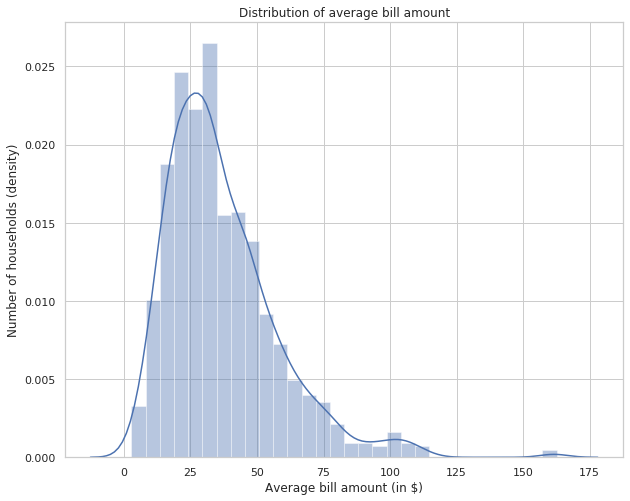

In [14]:
f, ax = plt.subplots(figsize=(10, 8))

sns.distplot(df_households_basket_payment_average)
ax.set_title('Distribution of average bill amount')
ax.set_xlabel('Average bill amount (in $)')
ax.set_ylabel('Number of households (density)')

plt.show()

Looking at the histogram of this statistic, we identify it as a right-skewed Gaussian distribution, with a few outliers.

#### Average Price of the Most Expensive Product

From another perspective, we can calculate a different statistic quantifying the spending habits of each household. This time we use the derived `PRODUCT_PRICE` to calculate the maximum product price in each basket and then average across for each household. 

In [15]:
df_households_basket_max_product_price = df_households_transactions.groupby(['household_key', 'BASKET_ID'])['PRODUCT_PRICE'].max()
df_households_basket_max_product_price_average = df_households_basket_max_product_price.groupby('household_key').mean()

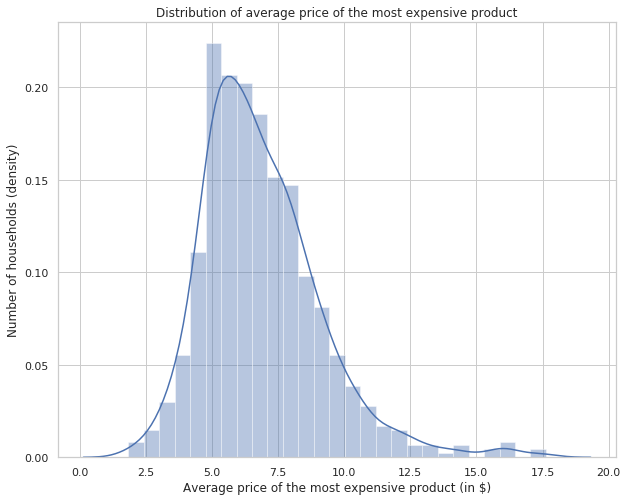

In [16]:
f, ax = plt.subplots(figsize=(10, 8))

sns.distplot(df_households_basket_max_product_price_average)
ax.set_title('Distribution of average price of the most expensive product')
ax.set_xlabel('Average price of the most expensive product (in $)')
ax.set_ylabel('Number of households (density)')

plt.show()

We observe from its histogram that this feature has a much more regular Gaussian distribution.

### Statistics Comparison

#### Correlation

Using a scatter plot, we would like to see it the two statistics are coorelated.

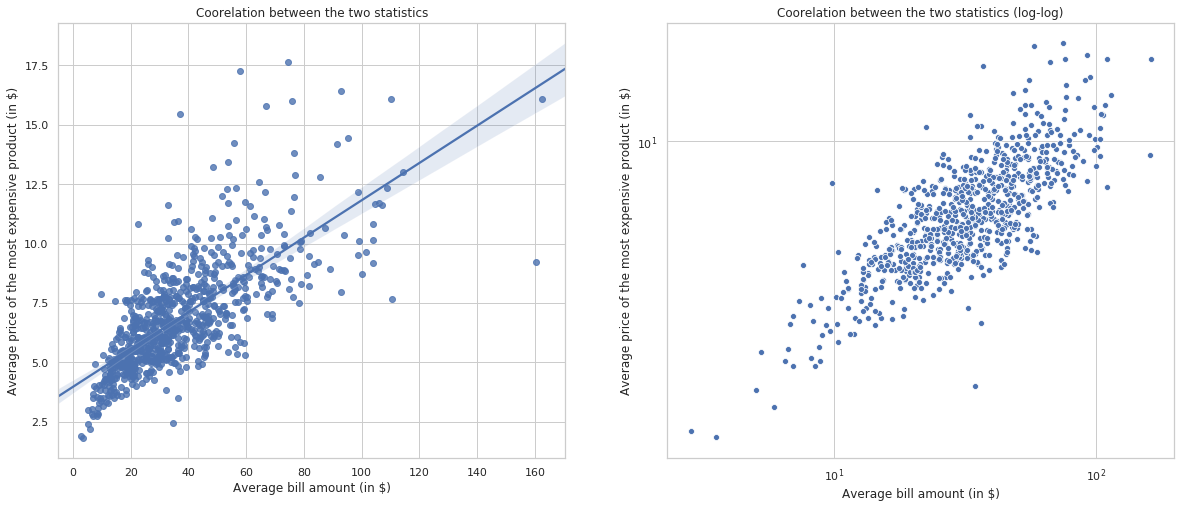

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.regplot(df_households_basket_payment_average, df_households_basket_max_product_price_average, ax=axes[0])
axes[0].set_title('Coorelation between the two statistics')
axes[0].set_xlabel('Average bill amount (in $)')
axes[0].set_ylabel('Average price of the most expensive product (in $)')

sns.scatterplot(df_households_basket_payment_average, df_households_basket_max_product_price_average, ax=axes[1])
axes[1].set_title('Coorelation between the two statistics (log-log)')
axes[1].set_xlabel('Average bill amount (in $)')
axes[1].set_ylabel('Average price of the most expensive product (in $)')
axes[1].set(xscale="log", yscale="log")

plt.show()

In [18]:
df_households_basket_payment_average.corr(df_households_basket_max_product_price_average, method='spearman')

0.7564947649602585

When using linear scales one can see an incrising monotonic associacion. Additionally, when viewing the data on log-log scales we can discern a linear trend, with large variance.

This suggests that the statistics might be almost equivalent (after some nonlinear transformation) and can be used interchangeably. We will support this further with the analyses in the following sections.

### Analysis of the Joint Distribution 

#### Household Income vs. Average Bill Amount

Using a boxplot we can view the distribution of the statistic across each household income category and perform a comparison very efficiently.

In [19]:
data = df_hh_demographic[['INCOME_DESC']].join(df_households_basket_payment_average)

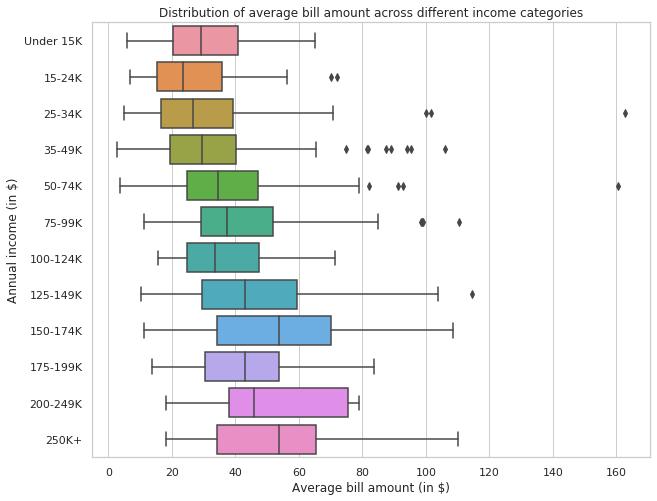

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(x='CUSTOMER_PAID', y='INCOME_DESC', data=data)
ax.set_title('Distribution of average bill amount across different income categories')
ax.set_xlabel('Average bill amount (in $)')
ax.set_ylabel('Annual income (in $)')

plt.show()

To our surprise, extreme spending are mostly observed for medium and lower income households.

Using a 2D histogram i.e. heatmap we can compare the relationship between income and the statistic in more detail by viewing their joint distribution.

In [21]:
mapping = dict(zip(data['INCOME_DESC'], data['INCOME_DESC'].cat.codes))

data['INCOME_DESC'] = data['INCOME_DESC'].astype(str).map(mapping)

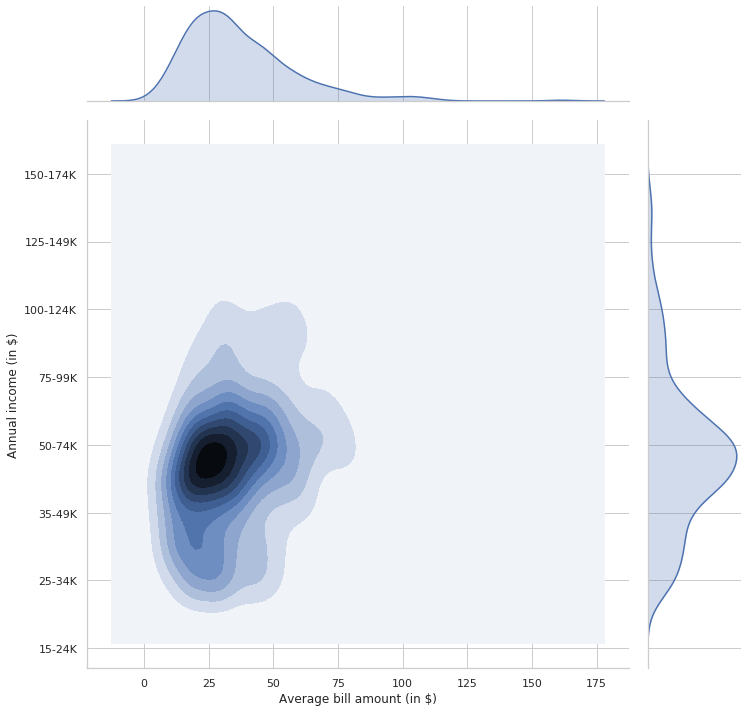

In [22]:
g = sns.jointplot(y='INCOME_DESC', x='CUSTOMER_PAID', data=data, kind='kde', height=10)
g.set_axis_labels(
    'Average bill amount (in $)',
    'Annual income (in $)'
)
g.ax_joint.set_yticklabels(income_desc_categories);

We can observe that the majority of the households are concentrated at the medium income values of 35-74K and lower average expenses of about \\$20 - \\$40.

#### Household Income vs. Average Price of the Most Expensive Product

Similarly, to begin the comparison between household income and maximum product prices we first merge the two features of each household.

In [23]:
data = df_hh_demographic[['INCOME_DESC']].join(df_households_basket_max_product_price_average)

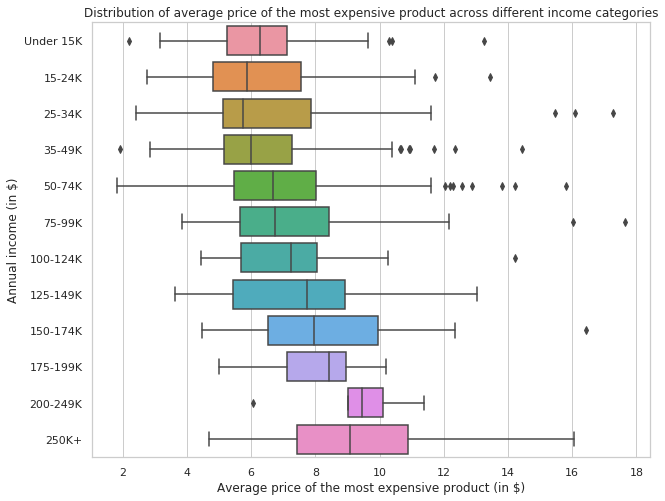

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(x='PRODUCT_PRICE', y='INCOME_DESC', data=data)
ax.set_title('Distribution of average price of the most expensive product across different income categories')
ax.set_xlabel('Average price of the most expensive product (in $)')
ax.set_ylabel('Annual income (in $)')

plt.show()

The phenomena related to the extreme values is present here as well. Additionally, an interesting difference is the huge range of values for the richest households, perhaps capturing the fact that these households mostly purchase the most expensive products.

In [25]:
mapping = dict(zip(data['INCOME_DESC'], data['INCOME_DESC'].cat.codes))

data['INCOME_DESC'] = data['INCOME_DESC'].astype(str).map(mapping)

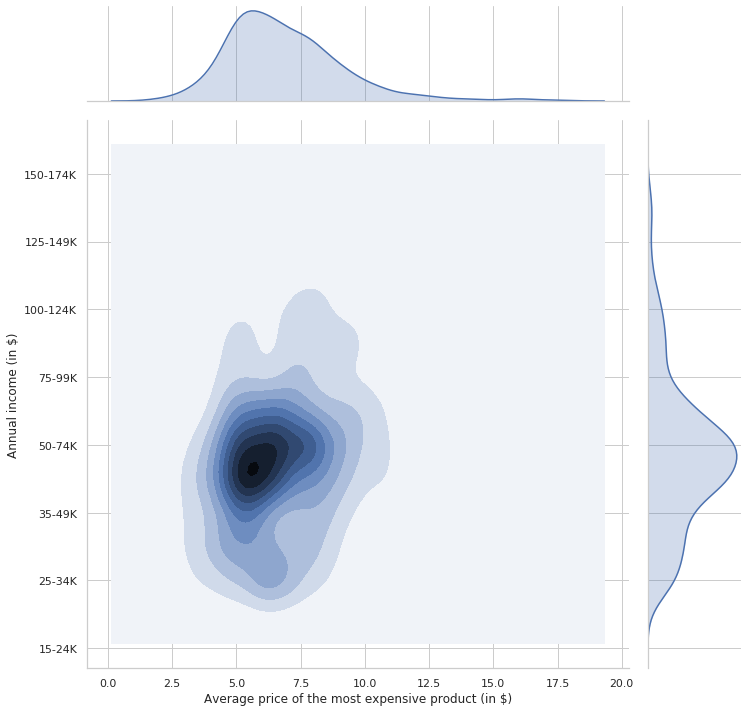

In [26]:
g = sns.jointplot(y='INCOME_DESC', x='PRODUCT_PRICE', data=data, kind='kde', height=10)
g.set_axis_labels(
    'Average price of the most expensive product (in $)',
    'Annual income (in $)'
)
g.ax_joint.set_yticklabels(income_desc_categories);

Analyzing the joint distribution using the jointplot, we observe that it is very similar in form to the one for the previous statistic, further proving their equivalence.

#### Weekly Expenses

In [54]:
df_households_weekly_expenses = df_households_transactions.groupby(['household_key', 'DAY'])['CUSTOMER_PAID'].sum().reset_index()
df_top_buyers = df_households_weekly_expenses.groupby('household_key')['CUSTOMER_PAID'].sum().sort_values(ascending=False).tail(4)
df_households_weekly_expenses

,household_key,DAY,CUSTOMER_PAID
0,1,51,77.66
1,1,67,41.10
2,1,88,26.90
3,1,94,62.93
4,1,101,53.45
...,...,...,...
113199,2499,670,6.68
113200,2499,673,210.83
113201,2499,693,11.87
113202,2499,704,277.37


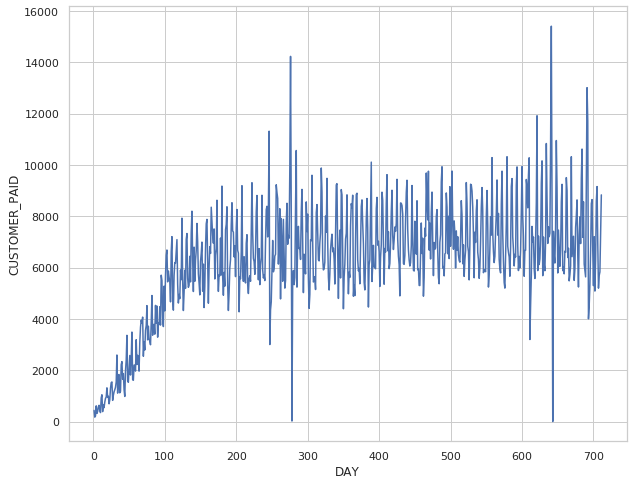

In [57]:
data = df_households_weekly_expenses.groupby('DAY')['CUSTOMER_PAID'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 8))

sns.lineplot(x='DAY', y='CUSTOMER_PAID', data=data)

plt.show()

### Demographic Analysis of Household Groups

In order to understand how family values influence the balance between household's expenses and income, we will analyze the demographic properties across 4 groups of households.

In [29]:
AVG_INCOME = '50-74K'
AVG_EXPENSES = 32.2431

In [30]:
df = df_hh_demographic.join(df_households_basket_payment_average.to_frame().rename(columns={'CUSTOMER_PAID': 'EXPENSES'}))

df_low_income_low_expenses = df[(df['INCOME_DESC'] <= AVG_INCOME) & (df['EXPENSES'] <= AVG_EXPENSES)]
df_low_income_high_expenses = df[(df['INCOME_DESC'] <= AVG_INCOME) & (df['EXPENSES'] > AVG_EXPENSES)]
df_high_income_low_expenses = df[(df['INCOME_DESC'] > AVG_INCOME) & (df['EXPENSES'] <= AVG_EXPENSES)]
df_high_income_high_expenses = df[(df['INCOME_DESC'] > AVG_INCOME) & (df['EXPENSES'] > AVG_EXPENSES)]

In [31]:
print('Percent of households with low income and low expenses:',
      round(len(df_low_income_low_expenses) / len(df_hh_demographic), 4))
print('Percent of households with low income and high expenses:',
      round(len(df_low_income_high_expenses) / len(df_hh_demographic), 4))
print('Percent of households with high income and low expenses:',
      round(len(df_high_income_low_expenses) / len(df_hh_demographic), 4))
print('Percent of households with high income and high expenses:',
      round(len(df_high_income_high_expenses) / len(df_hh_demographic), 4))

Percent of households with low income and low expenses: 0.4082
Percent of households with low income and high expenses: 0.3109
Percent of households with high income and low expenses: 0.0924
Percent of households with high income and high expenses: 0.1885


These groups were generated using the average income and average expenses. We split the households into: below (or above) average income and below (or above) average expenses.

#### Age

In [32]:
def plot_demographic(column_name, demographic_categories, demographic_feature_name):
    df = pd.concat([
        df_low_income_low_expenses[column_name].value_counts().rename('Low/ Low') / len(df_low_income_low_expenses),
        df_low_income_high_expenses[column_name].value_counts().rename('Low/ High') / len(df_low_income_high_expenses),
        df_high_income_low_expenses[column_name].value_counts().rename('High/ Low') / len(df_high_income_low_expenses),
        df_high_income_high_expenses[column_name].value_counts().rename('High/ High') / len(df_high_income_high_expenses)
    ], axis=1, sort=False)
    df.index = demographic_categories
    df = df.unstack().reset_index()
    df.columns = ['Income vs. Expenses', demographic_feature_name, 'Percentage of households']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.barplot(x=demographic_feature_name, y='Percentage of households', hue='Income vs. Expenses', data=df)
    ax.set_title(f'Demographic analysis of household groups - {demographic_feature_name}')
    
    plt.show()

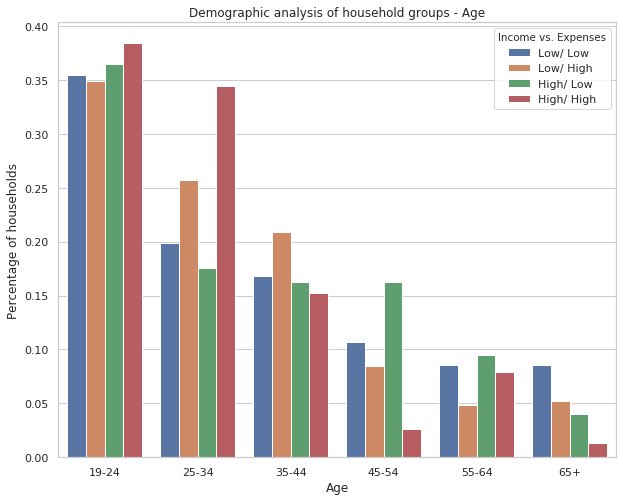

In [33]:
column_name = 'AGE_DESC'
demographic_categories = ['19-24', '25-34', '35-44', '45-54', '55-64', '65+']
demographic_feature_name = 'Age'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

From the age distribution of the household groups, we can make a few interesting observations. Among the households with the youngest members there is not a lot of variety in the income-expenses balance. Among the households with members of younger working ages high expenses seem to dominate. As we move to the households with older members lower expenses are more prevalent.

#### Martial Status

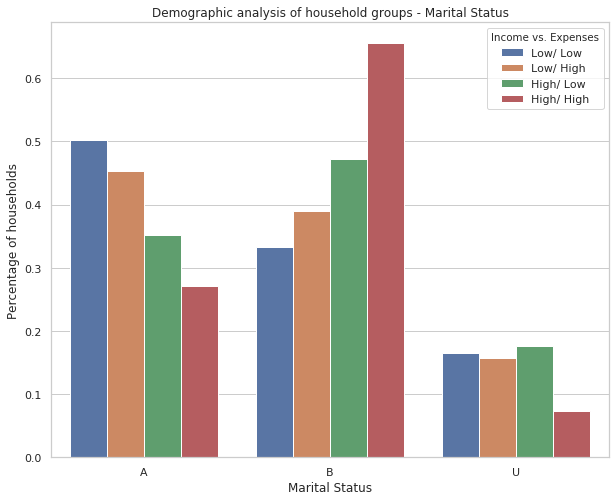

In [34]:
column_name = 'MARITAL_STATUS_CODE'
demographic_categories = ['A', 'B', 'U']
demographic_feature_name = 'Marital Status'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

For clarification, according to the dataset documentation the marital status codes `A`, `B`, and `U` stand for `Married`, `Single` and `Unknown` respectively. Interestingly, this plot efficiently captures classical differences between married and single life, as we observe that households with married members have more often lower income and must balance with lower expenses, while it is completely opposite for single member households, as they more frequently have higher income and are able to indulge in higher expenses.  

#### Homeowner Type

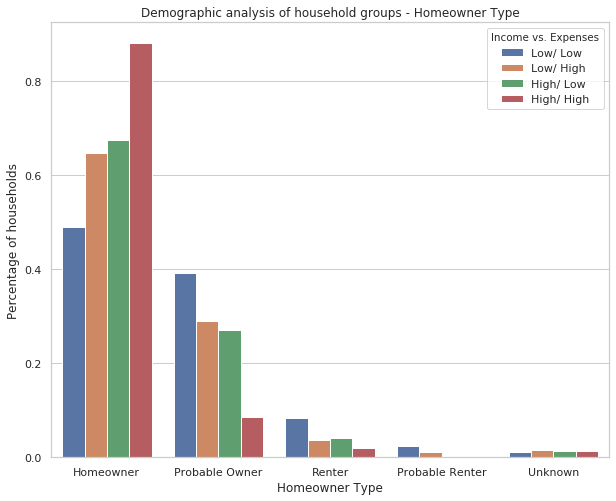

In [35]:
column_name = 'HOMEOWNER_DESC'
demographic_categories = ['Homeowner', 'Probable Owner', 'Renter', 'Probable Renter', 'Unknown']
demographic_feature_name = 'Homeowner Type'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

Analyzing the distribution of the type of homeownership we again obtain expected results, as it is understandable that it is most probable for households who are able to afford their own place of residence to have higher income and expenses, while renters usually have better sense of utilizing their limited income. 

#### Household Composition

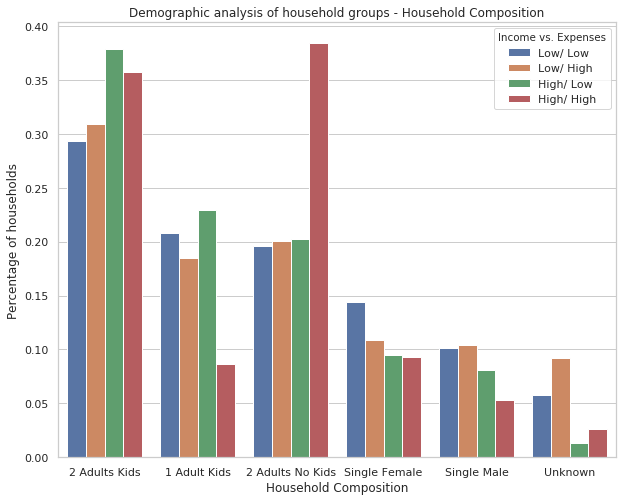

In [36]:
column_name = 'HH_COMP_DESC'
demographic_categories = ['2 Adults Kids', '1 Adult Kids', '2 Adults No Kids', 'Single Female', 'Single Male', 'Unknown']
demographic_feature_name = 'Household Composition'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

Among the different household compositions recorded in the data, we do not observe a lot of variety and this feature is not a good discriminator. However, we do observe two interesting discrepancies which can also be expected: couples with no children have the highest chance to be in the group with the highest income and expenses, while single parents have a harder time.

#### Household Size

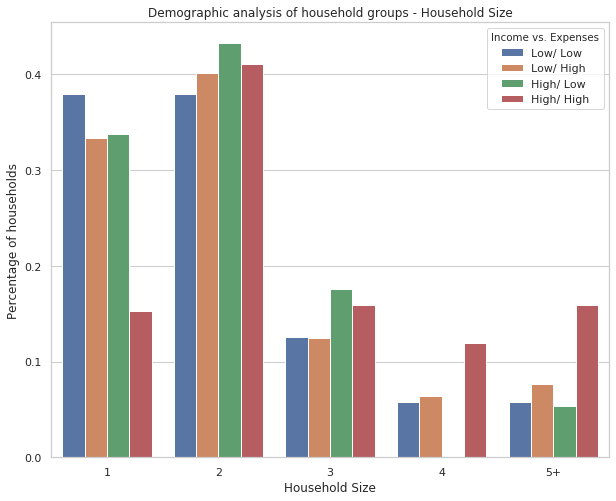

In [37]:
column_name = 'HOUSEHOLD_SIZE_DESC'
demographic_categories = ['1', '2', '3', '4', '5+']
demographic_feature_name = 'Household Size'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

The household size feature also displays very little significance for group distinction across different values. However, we can observe a trend that as the household size increases the probability of having lower income and expenses decreases, as only households with higher income can afford to have more children, but with that their expenses also increase.

#### Number of Children

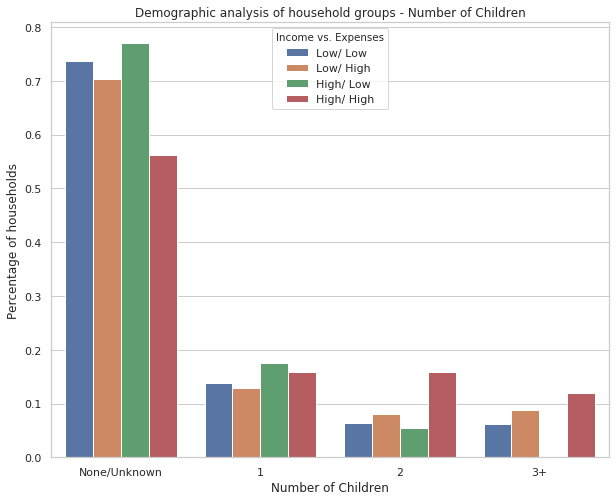

In [38]:
column_name = 'KID_CATEGORY_DESC'
demographic_categories = ['None/Unknown', '1', '2', '3+']
demographic_feature_name = 'Number of Children'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

The demographic records for the number of children can be inferred from previous features such as household size and household composition and as such in the plot we observe a similar trend as in the previous analysis of household size.

## Part 3: Applied ML

We are interested in whether there is existence of clusters in `hh_demographic` dataset. Since all the columns are categorical, we first transform the dataset using one-hot-encoding per column. Then, we apply PCA to project the dataset into 2 dimensional space, and finally apply KMeans clustering.

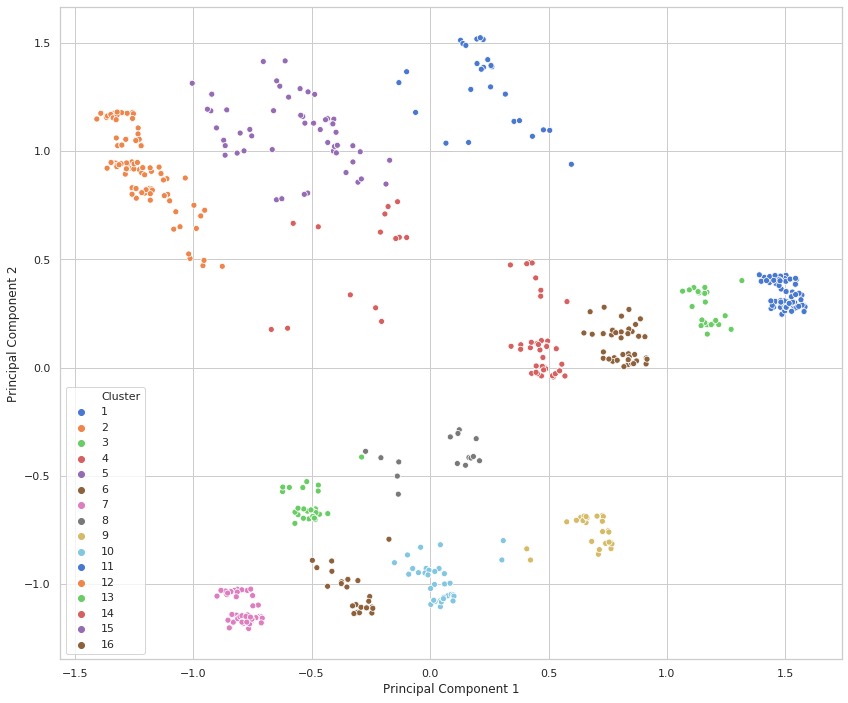

In [39]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

c = (df_hh_demographic['MARITAL_STATUS_CODE'] != 'U') & \
    (df_hh_demographic['HOMEOWNER_DESC'] != 'Unknown') & \
    (df_hh_demographic['KID_CATEGORY_DESC'] != 'None/Unknown')

k = 16

X = pd.get_dummies(df_hh_demographic)

pca = PCA(n_components=2).fit_transform(X)

kmeans = KMeans(n_clusters=k).fit(pca)

df = pd.DataFrame(np.concatenate((pca, kmeans.labels_.reshape(-1, 1)+1), axis=1), columns=['Principal Component 1', 'Principal Component 2', 'Cluster'])
df['Cluster'] = df['Cluster'].astype(int)

f, ax = plt.subplots(figsize=(14, 12))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2',  data=df, hue='Cluster', palette=sns.color_palette('muted', n_colors=k))
plt.show()

Although, PCA is hard to interpret, however, in the graph above we can see that there are 16 distinguishable clusters. This might suggest of cluster existence in higher dimensions and we will use this information for further insights.

## Part 4: Recap and Future Steps